In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [17]:
from keras.layers import Conv2D,Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.layers import Lambda,Conv2DTranspose,UpSampling2D
from keras.layers.convolutional import UpSampling2D
from keras.layers import MaxPooling2D

In [10]:
from DataGenerater import getTrainDataAndMask
from DataGenerater import batch_generator
import math
from skimage.external import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def tf_mean(input_x):
    return tf.reduce_mean(input_x,keepdims=True)

In [12]:
###this part is crucial to implemment custom layers
def mean_layer(channels):
    def mean_op(x):
        return Lambda(tf_mean)(x)
    return mean_op

In [18]:
def defModel(input_shape,num_class):
    ipt = Input(shape=input_shape)
    ###################
    
    x = Conv2D(10,kernel_size=3,padding='same',activation='relu')(ipt)
    x = mean_layer(10)(x)
    x = UpSampling2D(size=(256,256))(x)
    
    ###################
    x = Conv2D(num_class,kernel_size=1,padding='same',activation='softmax')(x)
    rg = Model(ipt,x)
    rg.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
    return rg

In [19]:
class Callbacks:
    checkpoint = ModelCheckpoint("weight/test.h5",save_best_only=True,save_weights_only=True)
class TrainData:
    trainX,trainY = getTrainDataAndMask("data/5056222_2016-07-02_RE1_3A_739012_part.tif","data/kklabel.png")
class Model:
    net = defModel(input_shape=(256,256,5),num_class=12)

In [20]:
Model.net.fit_generator(batch_generator(TrainData.trainX,TrainData.trainY,2),steps_per_epoch=200,
                           validation_data = batch_generator(TrainData.trainX,TrainData.trainY,2),validation_steps=2,
                           callbacks=[Callbacks.checkpoint],epochs=20,verbose=1)

Epoch 1/20
200/200 [==============================] - 6s 28ms/step - loss: 2.5743 - acc: 0.1385 - val_loss: 2.2068 - val_acc: 0.4657
Epoch 2/20
200/200 [==============================] - 4s 18ms/step - loss: 2.2549 - acc: 0.1716 - val_loss: 2.1415 - val_acc: 0.1584
Epoch 3/20
200/200 [==============================] - 4s 18ms/step - loss: 2.1714 - acc: 0.1873 - val_loss: 2.0724 - val_acc: 0.1867
Epoch 4/20
200/200 [==============================] - 4s 18ms/step - loss: 2.0670 - acc: 0.1996 - val_loss: 2.0281 - val_acc: 0.3208
Epoch 5/20
200/200 [==============================] - 4s 18ms/step - loss: 2.0024 - acc: 0.1990 - val_loss: 2.0123 - val_acc: 0.2551
Epoch 6/20
200/200 [==============================] - 4s 18ms/step - loss: 1.9614 - acc: 0.2642 - val_loss: 2.1181 - val_acc: 0.0422
Epoch 7/20
200/200 [==============================] - 4s 18ms/step - loss: 1.8856 - acc: 0.3347 - val_loss: 2.0428 - val_acc: 0.2679
Epoch 8/20
200/200 [==============================] - 4s 19ms/step - 

In [21]:
Model.net.load_weights("weight/test.h5")

In [22]:
def predictData(modelt,data_path):
    x_img = tiff.imread(data_path)/255
    ocr = np.zeros((math.ceil(x_img.shape[0]/256)*256,math.ceil(x_img.shape[1]/256)*256,5),'float16')
    ocr[0:x_img.shape[0],0:x_img.shape[1],:]=x_img
    tmp = np.zeros((math.ceil(x_img.shape[0]/256)*256,math.ceil(x_img.shape[1]/256)*256))
    for i in range(int(ocr.shape[0]/128)-1):
        for j in range(int(ocr.shape[1]/128)-1):
            pred = modelt.predict(np.expand_dims(ocr[128*i:128*(i+1)+128,128*j:128*(j+1)+128,:],0))
            pred = np.squeeze(pred)
            tmp[128*i:128*(i+1)+128,128*j:128*(j+1)+128] = pred.argmax(axis=2)
    rg =np.zeros((x_img.shape[0],x_img.shape[1]))
    rg = tmp[0:x_img.shape[0],0:x_img.shape[1]]
    tmpt = np.zeros((x_img.shape[0],x_img.shape[1],5))
    for t in range(5):
        tmpt[:,:,t]=rg
    tmpt[x_img==0] = 0
    return tmpt[:,:,0]

In [23]:
result = predictData(Model.net,"data/5056222_2016-07-02_RE1_3A_739012_part.tif")

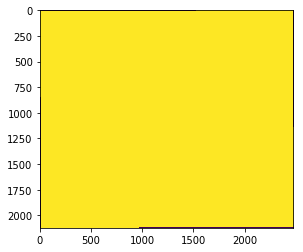

In [24]:
plt.imshow(result)